In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

                     Energy_Consumption
Start_DateTime                         
2018-01-01 17:49:00               6.504
2018-01-01 17:49:00               6.504
2018-01-02 08:52:00               2.481
2018-01-02 08:52:00               2.481
2018-01-02 21:11:00              15.046
...                                 ...
2019-08-06 08:48:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 10:17:00              11.060
2019-08-07 10:17:00              11.060

[968 rows x 1 columns]


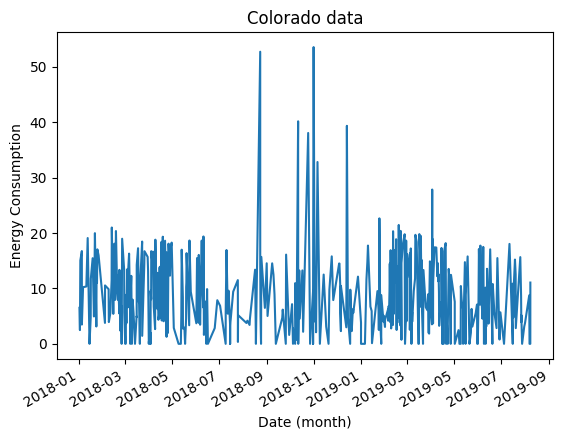

In [2]:
df = pd.read_csv('ColoradoData_Boulder.csv')
df.index = df['Start_DateTime']
df = df[['Start_DateTime', 'Energy_Consumption']].sort_index()
df.dropna(inplace=True)
df['Start_DateTime'] = pd.to_datetime(df['Start_DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Start_DateTime', inplace=True)
print(df)

plt.title("Colorado data")
plt.ylabel("Energy Consumption")
plt.xlabel("Date (month)")
plt.plot(df['Energy_Consumption'])
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

In [7]:
params = dict(
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  max_epochs = 1000,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 1, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 0,
  scaler = MinMaxScaler()
)

In [6]:
X = df.copy()
y = X['Energy_Consumption'].shift(-1).ffill()
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.25, shuffle=False)

preprocessing = params['scaler']
preprocessing.fit(X_train) # should only fit to training data
# prevents data leakage with info from val or test sets influencing the scaling with overly optimistic performance estimates

X_train = preprocessing.transform(X_train)
y_train = y_train.values.reshape((-1, 1))
X_val = preprocessing.transform(X_val)
y_val = y_val.values.reshape((-1, 1))
X_test = preprocessing.transform(X_test)
y_test = y_test.values.reshape((-1, 1))

In [ ]:
is_persistent = False #  num_workers>0, persistent_workers=True  only works in .py for me

train_dataset = TimeSeriesDataset(X_train, y_train, seq_len=params['seq_len'])
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'], persistent_workers=is_persistent)

val_dataset = TimeSeriesDataset(X_val, y_val, seq_len=params['seq_len'])
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'], persistent_workers=is_persistent)

test_dataset = TimeSeriesDataset(X_test, y_test, seq_len=params['seq_len'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'], persistent_workers=is_persistent)